In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import callbacks
import sklearn
from sklearn.metrics import roc_curve, auc
import imgaug.augmenters as iaa
from scipy.stats import wilcoxon

In [2]:
#check version numbers

!python -V
print(tf.__version__)
print(keras.__version__)
print(sklearn.__version__)

Python 3.9.9
2.7.0
2.7.0
1.0.1


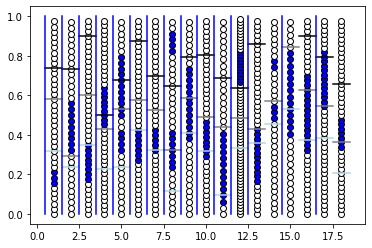

Number of slices per image: [38, 34, 40, 44, 34, 40, 40, 34, 34, 41, 32, 66, 42, 35, 32, 40, 44, 44]
Number of positive slices per image: [3, 9, 8, 9, 15, 7, 5, 11, 13, 8, 12, 11, 12, 5, 14, 16, 13, 7]
Number of positive slices per patient: [3, 9, 8, 9, 15, 7, 5, 11, 13, 8, 12, 11, 17, 30, 20]
Number of positive slices in total: 178


In [3]:
#plot and save locations of positive slices

posPatients = np.array([2,4,9,11,12,15,16,17,18,19,21,22,5,6,7,8,13,14])
brainLines = np.array([28,25,36,22,23,35,28,22,27,33,22,42,36,None,None,36,35,29])
jawLines = np.array([22,10,24,19,18,23,21,11,20,20,14,32,18,20,27,25,24,16])
neckLines = np.array([12,8,14,10,8,17,13,4,14,13,3,22,15,16,17,15,17,9])
numberOfSlices = []
locList = []

for i in range(18):
    if posPatients[i]==12:
        img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/12_anon/12_maski/12_maskit.img'
    else:
        img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}_anon/{}_maski/{}_maski.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    img = nib.load(img_path)
    img_data = img.get_fdata()
    locations = []
    numberOfSlices.append(img_data.shape[2])
    for j in range(img_data.shape[2]):
        slice = img_data[:,:,j]
        if np.max(slice)>0:
            locations.append(j)
    locList.append(np.array(locations))

for i in range(18):
    for j in range(numberOfSlices[i]):
        h=np.array(range(numberOfSlices[i]))[j]/numberOfSlices[i]
        if j in locList[i]:
            plt.scatter(i+1, h, color='blue', edgecolors='black')
        else:
            plt.scatter(i+1, h, color='white', edgecolors='black')
        if j==brainLines[i]:
            plt.plot([i+0.5,i+1.5],[h,h], color="black")
        if j==jawLines[i]:
            plt.plot([i+0.5,i+1.5],[h,h], color="gray")
        if j==neckLines[i]:
            plt.plot([i+0.5,i+1.5],[h,h], color="lightblue")
    if i not in [13,15,17]:
        plt.plot([i+0.5,i+0.5], [0,1], color="blue")
plt.show()

print('Number of slices per image:',numberOfSlices)

lenList = []
for i in range(18):
    lenList.append(len(locList[i])) 
print('Number of positive slices per image:',lenList)

posList = []

for i in range(18):
    img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}_anon/{}_nifti_pet/{}_nifti_pet.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    img = nib.load(img_path)
    img_data = img.get_fdata()
    pos = []
    for j in range(len(locList[i])):
        pos.append(np.array(img_data[:,:,locList[i][j]]))
    posList.append(pos)

posList = posList[0:12]+[posList[12]+posList[13]]+[posList[14]+posList[15]]+[posList[16]+posList[17]]

posLenList = []
for i in range(15):
    posLenList.append(len(posList[i])) 
print('Number of positive slices per patient:',posLenList)
print('Number of positive slices in total:',np.sum(np.array(posLenList)))

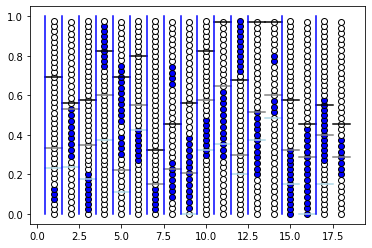

In [4]:
#choose the negative slices

negPatients = np.array([4,18,34,39,28,38,44,6,47,25,23,15,12,13,31,32,2,3])
negBrainLines = np.array([27,19,23,33,25,32,13,16,19,33,33,27,34,34,23,16,22,16])
negJawLines = np.array([13,18,14,24,8,22,6,8,7,23,22,12,18,21,13,10,16,10])
negNeckLines = np.array([9,8,7,15,4,17,None,None,0,13,12,8,13,17,6,0,6,None])
negNumberOfSlices = []

negLocList = [np.array([3, 4, 5]),
 np.array([10, 11, 12, 13, 14, 15, 16, 17, 18]),
 np.array([ 1,  2,  3, 4, 5, 6, 7, 8]),
 np.array([30, 31, 32, 33, 34, 35, 36, 37, 38]),
 np.array([11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 np.array([11, 12, 13, 14, 15, 16, 17]),
 np.array([1, 2, 3, 4, 5]),
 np.array([ 3,  4, 5, 6, 7, 8, 9, 23, 24, 25, 26]),
 np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]),
 np.array([12, 13, 14, 15, 16, 17, 18, 19]),
 np.array([10,  11,  12,  13,  14,  15,  16,  17, 18, 19, 20, 21]),
 np.array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]),
 np.array([7, 8, 9, 10, 11, 12, 13,  14,  15, 16, 17, 18]),
 np.array([18, 19, 20, 27, 28]),
 np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]),
 np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]),
 np.array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]),
 np.array([7, 8, 9, 10, 11, 12, 13])]

for i in range(18):
    img_path='C:/Users/Oona/Documents/Tpc/hnc/anom_data/negatiiviset/{}/N{}_nifti_pet/N{}_nifti_pet.img'.format(
        negPatients[i],negPatients[i],negPatients[i])
    img = nib.load(img_path)
    img_data = img.get_fdata()
    negNumberOfSlices.append(img_data.shape[2])

for i in range(18):
    for j in range(negNumberOfSlices[i]):
        h=np.array(range(negNumberOfSlices[i]))[j]/negNumberOfSlices[i]
        if j in negLocList[i]:
            plt.scatter(i+1, h, color='blue', edgecolors='black')
        else:
            plt.scatter(i+1, h, color='white', edgecolors='black')
        if j==negBrainLines[i]:
            plt.plot([i+0.5,i+1.5],[h,h], color="black")
        if j==negJawLines[i]:
            plt.plot([i+0.5,i+1.5],[h,h], color="gray")
        if j==negNeckLines[i]:
            plt.plot([i+0.5,i+1.5],[h,h], color="lightblue")
    if i not in [13,15,17]:
        plt.plot([i+0.5,i+0.5], [0,1], color="blue")
plt.show()


In [5]:
#save negative slices

negList = []

for i in range(18):
    img_path='C:/Users/Oona/Documents/Tpc/hnc/anom_data/negatiiviset/{}/N{}_nifti_pet/N{}_nifti_pet.img'.format(
        negPatients[i],negPatients[i],negPatients[i])
    img = nib.load(img_path)
    img_data = img.get_fdata()
    neg = []
    for j in range(len(negLocList[i])):
        neg.append(np.array(img_data[:,:,negLocList[i][j]]))
    negList.append(neg)

negLenList = []
for i in range(18):
    negLenList.append(len(negLocList[i])) 
print('Number of negative slices per image:',negLenList)

negList = negList[0:12]+[negList[12]+negList[13]]+[negList[14]+negList[15]]+[negList[16]+negList[17]]

Number of negative slices per image: [3, 9, 8, 9, 15, 7, 5, 11, 13, 8, 12, 11, 12, 5, 14, 16, 13, 7]


In [6]:
#plot one slice

img=posList[10][7] #0.1,4.5,10.7
img=cv2.resize(img,(128,128))
img=(img-np.min(img))/(np.max(img)-np.min(img))
plt.imshow(img)
plt.axis('off')
plt.show()

In [7]:
def divideIntoSets(posList,negList,img_width,img_height):

    numberOfTestSetPairs = 3
    posLenList = []
    for i in range(15):
        posLenList.append(len(posList[i]))
    testSetPairs = np.array(np.random.choice(range(15), size=numberOfTestSetPairs, replace=False))
    
    x_train=[]
    y_train=[]
    x_test=[]
    y_test=[]

    for i in range(15):
        if i in testSetPairs:
            for j in range(len(posList[i])):
                img=cv2.resize(negList[i][j],(img_width,img_height))
                img=(img-np.min(img))/(np.max(img)-np.min(img))*2-1
                x_test.append(img)
                y_test.append(0)
                img=cv2.resize(posList[i][j],(img_width,img_height))
                img=(img-np.min(img))/(np.max(img)-np.min(img))*2-1
                x_test.append(img)
                y_test.append(1)
        else:
            for j in range(len(posList[i])):
                img=cv2.resize(negList[i][j],(img_width,img_height))
                img=(img-np.min(img))/(np.max(img)-np.min(img))*2-1
                x_train.append(img)
                y_train.append(0)
                img=cv2.resize(posList[i][j],(img_width,img_height))
                img=(img-np.min(img))/(np.max(img)-np.min(img))*2-1
                x_train.append(img)
                y_train.append(1)

    x_train=np.array(x_train)
    y_train=np.array(y_train)
    x_test=np.array(x_test)
    y_test=np.array(y_test)

    return([x_train,y_train,x_test,y_test,testSetPairs])

In [8]:
def chlNumberTo3(sets):

    x_train=sets[0]
    x_test=sets[2]
    x_train1=[]
    x_test1=[]

    for i in range(x_train.shape[0]):
        x_train1.append(np.rollaxis(np.array([x_train[i],x_train[i],x_train[i]]),0,3))
    x_train1=np.array(x_train1)
    
    for i in range(x_test.shape[0]):
        x_test1.append(np.rollaxis(np.array([x_test[i],x_test[i],x_test[i]]),0,3))
    x_test1=np.array(x_test1)

    return([x_train1,sets[1],x_test1,sets[3],sets[4]])

In [9]:
def rbScale(img):

    imgHeight=img.shape[0]
    imgWidth=img.shape[1]

    img3=np.rollaxis(np.array([np.zeros((imgHeight,imgWidth)),np.zeros((imgHeight,imgWidth)),np.zeros((imgHeight,imgWidth))]),0,3)

    #img=(img-np.min(img))/(np.max(img)-np.min(img))*2-1

    for i in range(imgHeight):
        for j in range(imgWidth):
            k=img[i,j]
            if k<=-109/255:
                img3[i,j,0]=-1
                img3[i,j,1]=-1
                img3[i,j,2]=(255*k+182)/73
            elif k<=1/255:
                img3[i,j,0]=-1
                img3[i,j,1]=(255*k+54)/55
                img3[i,j,2]=-(255*k+54)/55
            elif k<=99/255:
                img3[i,j,0]=(255*k-50)/49
                img3[i,j,1]=1
                img3[i,j,2]=-1
            else:
                img3[i,j,0]=1
                img3[i,j,1]=(177-255*k)/78
                img3[i,j,2]=-1

    return img3

In [10]:
def rbScaleSets(sets):

    x_train=sets[0]
    x_test=sets[2]
    x_train1=[]
    x_test1=[]

    for i in range(x_train.shape[0]):
        x_train1.append(rbScale(x_train[i]))
    x_train1=np.array(x_train1)
    
    for i in range(x_test.shape[0]):
        x_test1.append(rbScale(x_test[i]))
    x_test1=np.array(x_test1)

    return([x_train1,sets[1],x_test1,sets[3],sets[4]])

In [11]:
def augment(sets):

    x_train = sets[0]
    y_train = sets[1]

    augmentation=iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.Affine(
            translate_percent={'x':(-0.05,0.05),'y':(-0.05,0.05)},
            rotate=(-10,10)
        )
    ])

    aug_x_train=np.concatenate((x_train,augmentation(images=x_train),augmentation(images=x_train)))
    aug_y_train=np.concatenate((y_train,y_train,y_train))

    return[aug_x_train,aug_y_train,sets[2],sets[3],sets[4]]

In [12]:
#define the deep model

def oneItDeepModel(sets):

    x_train = sets[0]
    y_train = sets[1]
    x_test = sets[2]

    img_width = x_train[0].shape[0]
    img_height = x_train[0].shape[1]
    if len(x_train[0].shape)==2:
        chl_number=1
    else:
        chl_number=x_train[0].shape[2]

    model = tf.keras.models.Sequential([layers.Conv2D(16, 3, activation='relu', input_shape=(img_width,img_height,chl_number)),
                                    layers.Conv2D(16, 3, activation='relu'),
                                    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                                    layers.Conv2D(32, 3, activation='relu'),
                                    layers.Conv2D(32, 3, activation='relu'),
                                    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                                    layers.Conv2D(64, 3, activation='relu'),
                                    layers.Conv2D(64, 3, activation='relu'),
                                    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                                    layers.Conv2D(128, 3, activation='relu'),
                                    layers.Conv2D(128, 3, activation='relu'),
                                    layers.MaxPooling2D(strides=(2, 2)),
                                    layers.Flatten(),
                                    layers.Dense(128, activation='relu'),
                                    layers.Dense(64, activation='relu'),
                                    layers.Dense(32, activation='relu'),
                                    layers.Dense(1, activation='sigmoid')
    ] 
    )

    model.compile(
        optimizer=keras.optimizers.SGD(1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy()]
    )

    earlystopping = callbacks.EarlyStopping(monitor='val_loss',
        mode='min', patience=5, restore_best_weights=True)


    model.fit(x=x_train,
                    y=y_train,
                    epochs=50,
                    validation_split=0.3,
                    callbacks=[earlystopping],
                    shuffle=True)

    predictions=model.predict(x_test)
    trainPreds=model.predict(x_train)

    return([predictions,trainPreds])

In [13]:
#the transfer learning model

def oneItTransferLearning(sets,modelName):

    x_train = sets[0]
    y_train = sets[1]
    x_test = sets[2]

    img_width = x_train[0].shape[0]
    img_height = x_train[0].shape[1]
    chl_number = 3
    
    if modelName=='DenseNet169':
        base_model = keras.applications.DenseNet169(weights='imagenet',input_shape=(img_width,img_height,chl_number),include_top=False)
        ntf_model = keras.applications.DenseNet169(weights=None,input_shape=(img_width,img_height,chl_number),include_top=False)
    if modelName=='InceptionV3':
        base_model = keras.applications.InceptionV3(weights='imagenet',input_shape=(img_width,img_height,chl_number),include_top=False)
        ntf_model = keras.applications.InceptionV3(weights=None,input_shape=(img_width,img_height,chl_number),include_top=False)
    if modelName=='MobileNet':
        base_model = keras.applications.MobileNet(weights='imagenet',input_shape=(img_width,img_height,chl_number),include_top=False)
        ntf_model = keras.applications.MobileNet(weights=None,input_shape=(img_width,img_height,chl_number),include_top=False)
    if modelName=='ResNet50':
        base_model = keras.applications.ResNet50(weights='imagenet',input_shape=(img_width,img_height,chl_number),include_top=False)
        ntf_model = keras.applications.ResNet50(weights=None,input_shape=(img_width,img_height,chl_number),include_top=False)
    if modelName=='Xception':
        base_model = keras.applications.Xception(weights='imagenet',input_shape=(img_width,img_height,chl_number),include_top=False)
        ntf_model = keras.applications.Xception(weights=None,input_shape=(img_width,img_height,chl_number),include_top=False)

    earlystopping = callbacks.EarlyStopping(monitor='val_loss',
                mode='min', patience=5, restore_best_weights=True)

    ntf_model.trainable = True
    inputs = keras.Input(shape=(img_width,img_height,chl_number))
    x = ntf_model(inputs, training=True)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.SGD(1e-3),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[keras.metrics.BinaryAccuracy()])
    model.fit(x=x_train, y=y_train, epochs=50, validation_split=0.3, callbacks=[earlystopping], shuffle=True)
    ntfPredictions=model.predict(x_test)
    ntfTrainPreds=model.predict(x_train)

    base_model.trainable = False
    inputs = keras.Input(shape=(img_width,img_height,chl_number))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.SGD(1e-3),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[keras.metrics.BinaryAccuracy()])
    model.fit(x=x_train, y=y_train, epochs=50, validation_split=0.3, callbacks=[earlystopping], shuffle=True)
    predictionsWithoutFineTuning=model.predict(x_test)
    trainPredsWithoutFineTuning=model.predict(x_train)

    base_model.trainable = True
    model.compile(optimizer=keras.optimizers.SGD(1e-5),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
    model.fit(x=x_train, y=y_train, epochs=5, validation_split=0.3, shuffle=True)

    predictions=model.predict(x_test)
    trainPreds=model.predict(x_train)

    return([ntfPredictions, predictionsWithoutFineTuning, predictions, ntfTrainPreds, trainPredsWithoutFineTuning, trainPreds])

In [3]:
def evaluatePreds(predictions,trainPreds):

    y_train=np.array([0,1]*int(trainPreds.shape[0]/2))
    y_test=np.array([0,1]*int(predictions.shape[0]/2))
    fpr, tpr, thresholds = roc_curve(y_train, trainPreds, drop_intermediate=False)
    J_stats = tpr - fpr
    opt_threshold = thresholds[np.argmax(J_stats)]

    TN = 0
    FN = 0
    TP = 0
    FP = 0

    for i in range(len(y_test)):
        if predictions[i]<opt_threshold:
            if y_test[i]==0:
                TN+=1
            else:
                FN+=1
        else:
            if y_test[i]==1:
                TP+=1
            else:
                FP+=1

    acc = (TN+TP)/(TN+FN+TP+FP)
    sen = TP/(FN+TP)
    spe = TN/(TN+FP)
    fpr, tpr, thresholds = roc_curve(y_test, predictions, drop_intermediate=False)
    auc1 = auc(fpr, tpr)

    return([acc,sen,spe,auc1])

In [15]:
for k in range(16,17):

    sets=divideIntoSets(posList,negList,128,128)
    testSetPairs=sets[4]
    outputDeepModel = oneItDeepModel(sets)
    sets3=chlNumberTo3(sets)

    outputDenseNet169 = oneItTransferLearning(sets3,'DenseNet169')
    outputInceptionV3 = oneItTransferLearning(sets3,'InceptionV3')
    outputMobileNet = oneItTransferLearning(sets3,'MobileNet')
    outputResNet50 = oneItTransferLearning(sets3,'ResNet50')
    outputXception = oneItTransferLearning(sets3,'Xception')

    rbSets=rbScaleSets(sets)
    outputRbDeepModel = oneItDeepModel(rbSets)
    outputRbDenseNet169 = oneItTransferLearning(rbSets,'DenseNet169')
    outputRbInceptionV3 = oneItTransferLearning(rbSets,'InceptionV3')
    outputRbMobileNet = oneItTransferLearning(rbSets,'MobileNet')
    outputRbResNet50 = oneItTransferLearning(rbSets,'ResNet50')
    outputRbXception = oneItTransferLearning(rbSets,'Xception')

    augSets = augment(sets)
    outputAugDeepModel = oneItDeepModel(augSets)
    augSets3=chlNumberTo3(augSets)

    outputAugDenseNet169 = oneItTransferLearning(augSets3,'DenseNet169')
    outputAugInceptionV3 = oneItTransferLearning(augSets3,'InceptionV3')
    outputAugMobileNet = oneItTransferLearning(augSets3,'MobileNet')
    outputAugResNet50 = oneItTransferLearning(augSets3,'ResNet50')
    outputAugXception = oneItTransferLearning(augSets3,'Xception')

    augRbSets=rbScaleSets(augSets)
    outputAugRbDeepModel = oneItDeepModel(augRbSets)
    outputAugRbDenseNet169 = oneItTransferLearning(augRbSets,'DenseNet169')
    outputAugRbInceptionV3 = oneItTransferLearning(augRbSets,'InceptionV3')
    outputAugRbMobileNet = oneItTransferLearning(augRbSets,'MobileNet')
    outputAugRbResNet50 = oneItTransferLearning(augRbSets,'ResNet50')
    outputAugRbXception = oneItTransferLearning(augRbSets,'Xception')

    np.savetxt('testSetPairs1_{}.txt'.format(k), testSetPairs)

    number=outputDeepModel[0].shape[0]

    array=np.zeros((64,number))

    for j in range(number):
        array[0,j]=outputDeepModel[0][j]
        array[1,j]=outputDenseNet169[0][j]
        array[2,j]=outputDenseNet169[1][j]
        array[3,j]=outputDenseNet169[2][j]
        array[4,j]=outputInceptionV3[0][j]
        array[5,j]=outputInceptionV3[1][j]
        array[6,j]=outputInceptionV3[2][j]
        array[7,j]=outputMobileNet[0][j]
        array[8,j]=outputMobileNet[1][j]
        array[9,j]=outputMobileNet[2][j]
        array[10,j]=outputResNet50[0][j]
        array[11,j]=outputResNet50[1][j]
        array[12,j]=outputResNet50[2][j]
        array[13,j]=outputXception[0][j]
        array[14,j]=outputXception[1][j]
        array[15,j]=outputXception[2][j]
        array[16,j]=outputRbDeepModel[0][j]
        array[17,j]=outputRbDenseNet169[0][j]
        array[18,j]=outputRbDenseNet169[1][j]
        array[19,j]=outputRbDenseNet169[2][j]
        array[20,j]=outputRbInceptionV3[0][j]
        array[21,j]=outputRbInceptionV3[1][j]
        array[22,j]=outputRbInceptionV3[2][j]
        array[23,j]=outputRbMobileNet[0][j]
        array[24,j]=outputRbMobileNet[1][j]
        array[25,j]=outputRbMobileNet[2][j]
        array[26,j]=outputRbResNet50[0][j]
        array[27,j]=outputRbResNet50[1][j]
        array[28,j]=outputRbResNet50[2][j]
        array[29,j]=outputRbXception[0][j]
        array[30,j]=outputRbXception[1][j]
        array[31,j]=outputRbXception[2][j]
        array[32,j]=outputAugDeepModel[0][j]
        array[33,j]=outputAugDenseNet169[0][j]
        array[34,j]=outputAugDenseNet169[1][j]
        array[35,j]=outputAugDenseNet169[2][j]
        array[36,j]=outputAugInceptionV3[0][j]
        array[37,j]=outputAugInceptionV3[1][j]
        array[38,j]=outputAugInceptionV3[2][j]
        array[39,j]=outputAugMobileNet[0][j]
        array[40,j]=outputAugMobileNet[1][j]
        array[41,j]=outputAugMobileNet[2][j]
        array[42,j]=outputAugResNet50[0][j]
        array[43,j]=outputAugResNet50[1][j]
        array[44,j]=outputAugResNet50[2][j]
        array[45,j]=outputAugXception[0][j]
        array[46,j]=outputAugXception[1][j]
        array[47,j]=outputAugXception[2][j]
        array[48,j]=outputAugRbDeepModel[0][j]
        array[49,j]=outputAugRbDenseNet169[0][j]
        array[50,j]=outputAugRbDenseNet169[1][j]
        array[51,j]=outputAugRbDenseNet169[2][j]
        array[52,j]=outputAugRbInceptionV3[0][j]
        array[53,j]=outputAugRbInceptionV3[1][j]
        array[54,j]=outputAugRbInceptionV3[2][j]
        array[55,j]=outputAugRbMobileNet[0][j]
        array[56,j]=outputAugRbMobileNet[1][j]
        array[57,j]=outputAugRbMobileNet[2][j]
        array[58,j]=outputAugRbResNet50[0][j]
        array[59,j]=outputAugRbResNet50[1][j]
        array[60,j]=outputAugRbResNet50[2][j]
        array[61,j]=outputAugRbXception[0][j]
        array[62,j]=outputAugRbXception[1][j]
        array[63,j]=outputAugRbXception[2][j]

    np.savetxt('ite1_{}_{}.txt'.format(k,number), array)

    number=outputDeepModel[1].shape[0]

    array=np.zeros((32,number))

    for j in range(number):
        array[0,j]=outputDeepModel[1][j]
        array[1,j]=outputDenseNet169[3][j]
        array[2,j]=outputDenseNet169[4][j]
        array[3,j]=outputDenseNet169[5][j]
        array[4,j]=outputInceptionV3[3][j]
        array[5,j]=outputInceptionV3[4][j]
        array[6,j]=outputInceptionV3[5][j]
        array[7,j]=outputMobileNet[3][j]
        array[8,j]=outputMobileNet[4][j]
        array[9,j]=outputMobileNet[5][j]
        array[10,j]=outputResNet50[3][j]
        array[11,j]=outputResNet50[4][j]
        array[12,j]=outputResNet50[5][j]
        array[13,j]=outputXception[3][j]
        array[14,j]=outputXception[4][j]
        array[15,j]=outputXception[5][j]
        array[16,j]=outputRbDeepModel[1][j]
        array[17,j]=outputRbDenseNet169[3][j]
        array[18,j]=outputRbDenseNet169[4][j]
        array[19,j]=outputRbDenseNet169[5][j]
        array[20,j]=outputRbInceptionV3[3][j]
        array[21,j]=outputRbInceptionV3[4][j]
        array[22,j]=outputRbInceptionV3[5][j]
        array[23,j]=outputRbMobileNet[3][j]
        array[24,j]=outputRbMobileNet[4][j]
        array[25,j]=outputRbMobileNet[5][j]
        array[26,j]=outputRbResNet50[3][j]
        array[27,j]=outputRbResNet50[4][j]
        array[28,j]=outputRbResNet50[5][j]
        array[29,j]=outputRbXception[3][j]
        array[30,j]=outputRbXception[4][j]
        array[31,j]=outputRbXception[5][j]

    np.savetxt('train1_{}_{}.txt'.format(k,number), array)

    number=outputAugDeepModel[1].shape[0]

    array=np.zeros((32,number))

    for j in range(number):
        array[0,j]=outputAugDeepModel[1][j]
        array[1,j]=outputAugDenseNet169[3][j]
        array[2,j]=outputAugDenseNet169[4][j]
        array[3,j]=outputAugDenseNet169[5][j]
        array[4,j]=outputAugInceptionV3[3][j]
        array[5,j]=outputAugInceptionV3[4][j]
        array[6,j]=outputAugInceptionV3[5][j]
        array[7,j]=outputAugMobileNet[3][j]
        array[8,j]=outputAugMobileNet[4][j]
        array[9,j]=outputAugMobileNet[5][j]
        array[10,j]=outputAugResNet50[3][j]
        array[11,j]=outputAugResNet50[4][j]
        array[12,j]=outputAugResNet50[5][j]
        array[13,j]=outputAugXception[3][j]
        array[14,j]=outputAugXception[4][j]
        array[15,j]=outputAugXception[5][j]
        array[16,j]=outputAugRbDeepModel[1][j]
        array[17,j]=outputAugRbDenseNet169[3][j]
        array[18,j]=outputAugRbDenseNet169[4][j]
        array[19,j]=outputAugRbDenseNet169[5][j]
        array[20,j]=outputAugRbInceptionV3[3][j]
        array[21,j]=outputAugRbInceptionV3[4][j]
        array[22,j]=outputAugRbInceptionV3[5][j]
        array[23,j]=outputAugRbMobileNet[3][j]
        array[24,j]=outputAugRbMobileNet[4][j]
        array[25,j]=outputAugRbMobileNet[5][j]
        array[26,j]=outputAugRbResNet50[3][j]
        array[27,j]=outputAugRbResNet50[4][j]
        array[28,j]=outputAugRbResNet50[5][j]
        array[29,j]=outputAugRbXception[3][j]
        array[30,j]=outputAugRbXception[4][j]
        array[31,j]=outputAugRbXception[5][j]

    np.savetxt('trainAug1_{}_{}.txt'.format(k,number), array)

Epoch 1/50
7/7 [==============================] - 8s 1s/step - loss: 0.6927 - binary_accuracy: 0.5980 - val_loss: 0.6926 - val_binary_accuracy: 0.5909
Epoch 2/50
7/7 [==============================] - 5s 747ms/step - loss: 0.6926 - binary_accuracy: 0.6225 - val_loss: 0.6926 - val_binary_accuracy: 0.5682
Epoch 3/50
7/7 [==============================] - 5s 735ms/step - loss: 0.6925 - binary_accuracy: 0.6176 - val_loss: 0.6926 - val_binary_accuracy: 0.5227
Epoch 4/50
7/7 [==============================] - 5s 709ms/step - loss: 0.6924 - binary_accuracy: 0.6373 - val_loss: 0.6926 - val_binary_accuracy: 0.4545
Epoch 5/50
7/7 [==============================] - 5s 701ms/step - loss: 0.6923 - binary_accuracy: 0.6275 - val_loss: 0.6926 - val_binary_accuracy: 0.4773
Epoch 6/50
7/7 [==============================] - 5s 709ms/step - loss: 0.6923 - binary_accuracy: 0.6471 - val_loss: 0.6926 - val_binary_accuracy: 0.4545
Epoch 7/50
7/7 [==============================] - 5s 703ms/step - loss: 0.6922 

In [26]:
df=np.zeros((4))
filenames = os.listdir('C:/Users/Oona/Documents/Tpc/hnc/tfl/')
j=39
for k in range(1,16): 
    for i in range(len(filenames)):
        if filenames[i][0:5]=='ite1_':
            if filenames[i][4:7]=='_{}_'.format(k) or filenames[i][4:8]=='_{}_'.format(k):
                if filenames[i][-8:-6]=='_1':
                    number=int(filenames[i][-7:-4])
                else:
                    number=int(filenames[i][-6:-4])
                array=np.loadtxt(filenames[i]).reshape(64,number)
                predictions=array[j,:]
    if j<32:
        for i in range(len(filenames)):
            if filenames[i][0:7]=='train1_':
                if filenames[i][6:9]=='_{}_'.format(k) or filenames[i][6:10]=='_{}_'.format(k):
                    number=int(filenames[i][-7:-4])
                    array=np.loadtxt(filenames[i]).reshape(32,number)
                    trainPreds=array[j,:]
    else:
        for i in range(len(filenames)):
            if filenames[i][0:10]=='trainAug1_':
                if filenames[i][9:12]=='_{}_'.format(k) or filenames[i][9:13]=='_{}_'.format(k):
                    number=int(filenames[i][-7:-4])
                    array=np.loadtxt(filenames[i]).reshape(32,number)
                    trainPreds=array[j-32,:]
    df=np.vstack((df,np.array(evaluatePreds(predictions,trainPreds))))
df=np.delete(df,(0),axis=0)
print(round(np.median(df[:,0]),3))
print(round(np.median(df[:,1]),3))
print(round(np.median(df[:,2]),3))
print(round(np.median(df[:,3]),3))
x=df[:,3]
#y=df[:,3]

0.793
0.773
0.821
0.912


In [27]:
print(np.median(x))
print(np.median(y))
wilcoxon(x,y)

0.9116735537190084
0.9137418203450327


c:\Users\Oona\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


WilcoxonResult(statistic=32.0, pvalue=0.19812291175396723)